# Membership Pricing Risk Analysis  

Tim Velasquez  
2023-05-11  

## Background  

The purpose of this simulation exercise is to understand the potential risk and benefits of the proposed pricing structure for memberships that is set to be piloted at the end of 2023 Q2. The main questions to be answered are:  

1. What are the ideal conditions in which we may break even?
2. What is the potential loss we may see compared to the previous month and same time last year in 2022?  

## Approach  

The general approach we will take to understand the breadth of risk is to run a Monte Carlo simulation based on 2022's ride revenue and customer count/growth performance for the following markets:  

- MNE (Minneapolis)
- NRC (New Rochelle)

These are some of the top choices for piloting since their demographic makeup is a close representation of the rest of our markets when it comes to demographic makeup. Previous studies have tagged SAR and PNC as additionally choices but these have pre-existing pilots underway that we want to prevent any overlap and confounding when it comes to A/B testing. 

### a. Simulation Framework

The simulation will use probability distributions both measured and assumed based on historical data from 2022. Specifically, we will measure:

- Total revenue spent per customer
- Total number of rides taken per customer
- Number of new users in a given month

Each iteration of the simulation will conduct the following stochastic steps at the month level:

1. How many new customers signed up and took a ride in that month?
2. How many of existing customers signed up for a membership?
3. How many of the new customers signed up for a membership?
4. ASSUME customers will generally take the same number of rides as last year
5. Assume memberships will have some probability of taking up to 45% more rides
6. What is the percentage of customers that will be active the month after and the month after that?
    - Rerun steps 1-5 in month_1
    - Then rerun 6 for month_2
        - Rerun steps 1-5 in month_2  


### b. Simulation Inputs

- Customer (Existing) Uptake Percentage: $$ Beta(\alpha=2, \beta=8)  $$
- Customer (New) Uptake Percentage: $$ Beta(\alpha=4, \beta=6) $$
- Percent increase of new signups: $$ Beta(\alpha=1, \beta=9) $$
- Probability customer takes median number of rides at same time last year: $$ Beta(\alpha=5, \beta=5) $$
- Change in Rides compared to last year: $$ N(\mu=.15, \sigma=0.1) $$
- Probability a customer (Membership) will be active in next month: $$ Beta(\alpha=7, \beta=3) $$
- Probability a customer (Standard) will be active in next month: $$ Beta(\alpha=2, \beta=8) $$
- Assume median monthly ride count = 3
- Normal price per ride: $$ Gamme(k=3, \theta=1.8) $$
- Assuming behaviors will model high riding season


## Analysis of MNE and NRC

### a. 2022 Analysis

How did MNE perform in each of the months in Q3 in 2022? It looks like Minneapolis opened in August. Ride price generally takes on a log normal distribution with centrality around `$5` but can go up to `$40` realistically and then upwards of $80 per ride. Let's assume the median trip distance is 1.8 miles and generally follows a lognormal distribution (avg is closer to 2.0 miles).

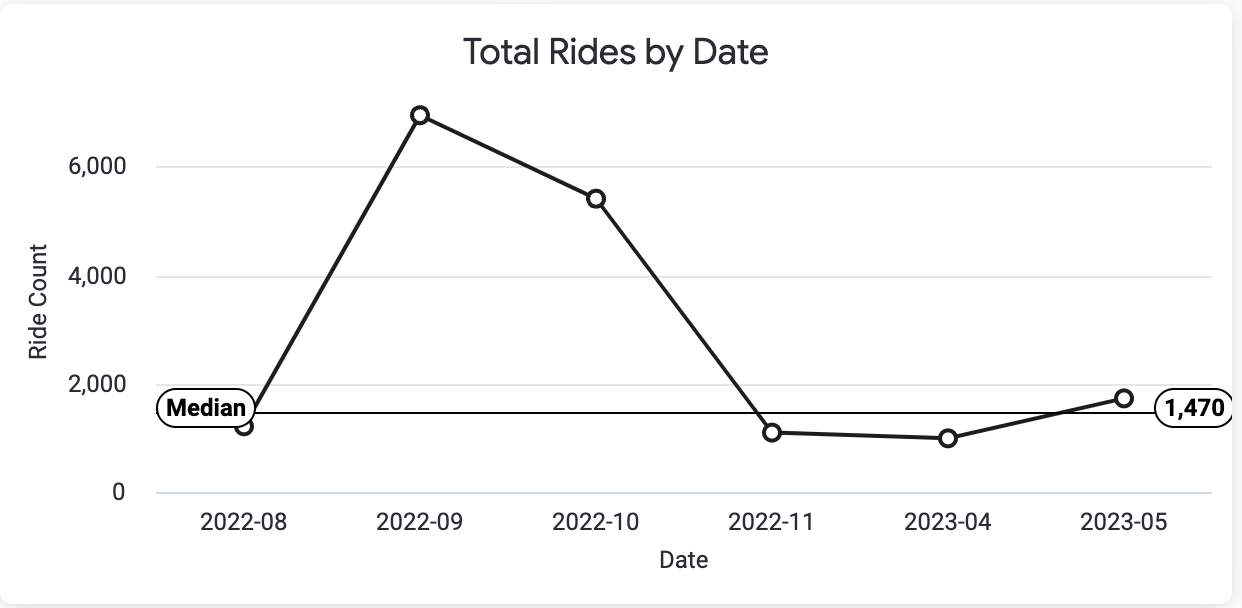  
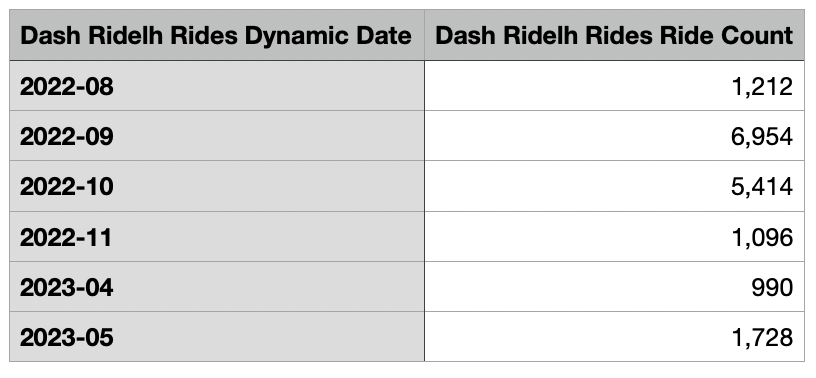  
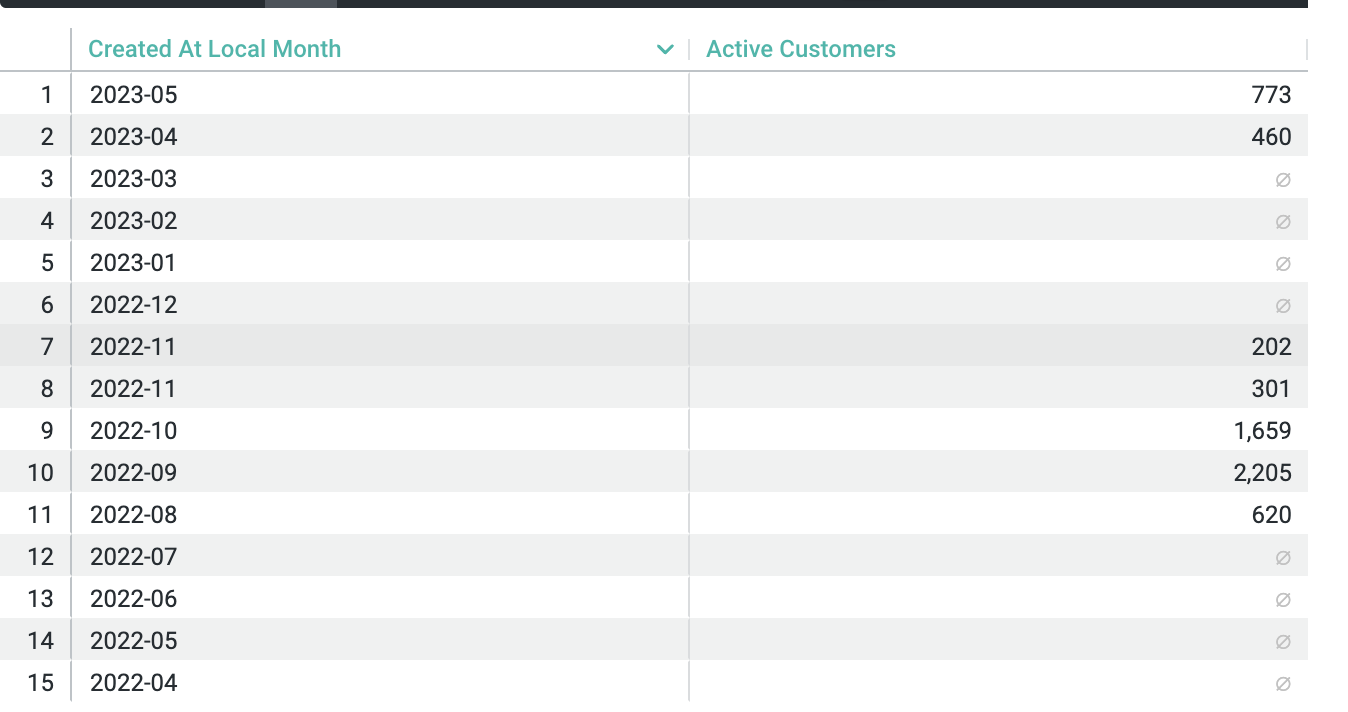  
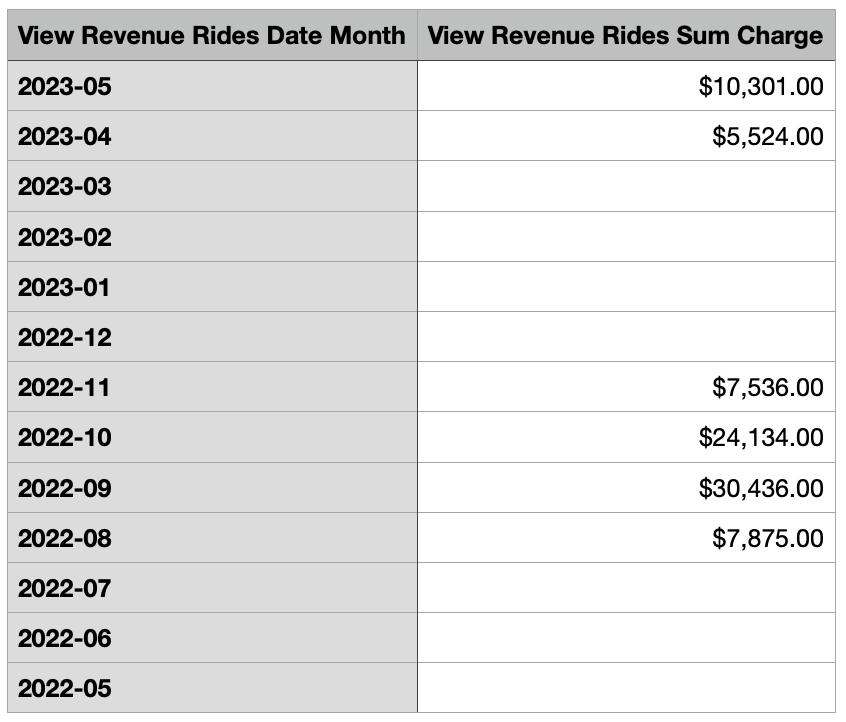  
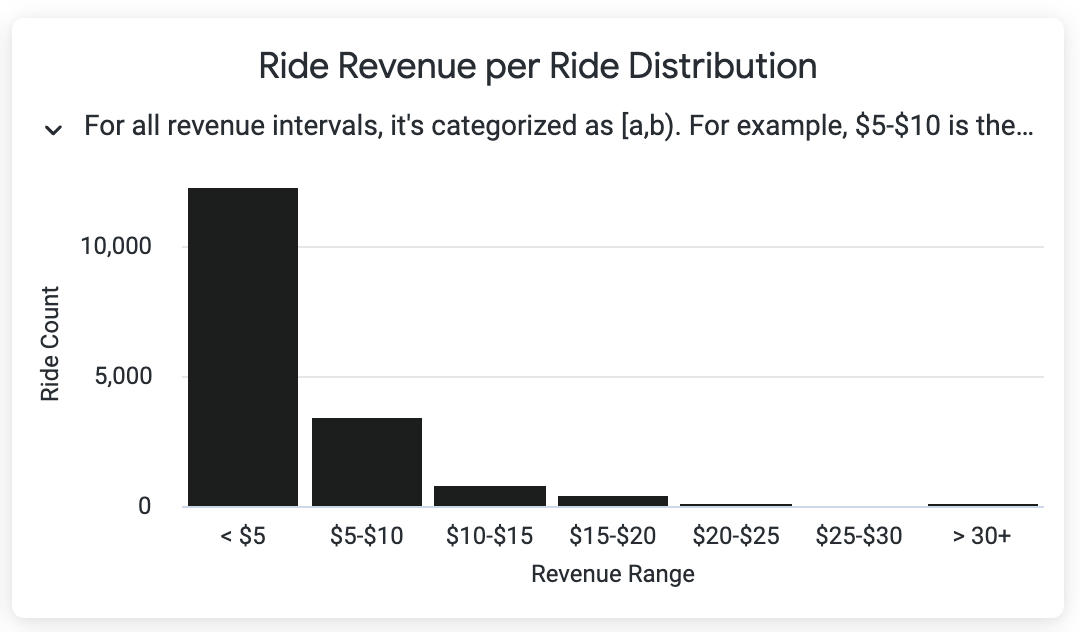


How did NRC perform in each of the months in Q3 in 2022? It's been active longer than MNE.
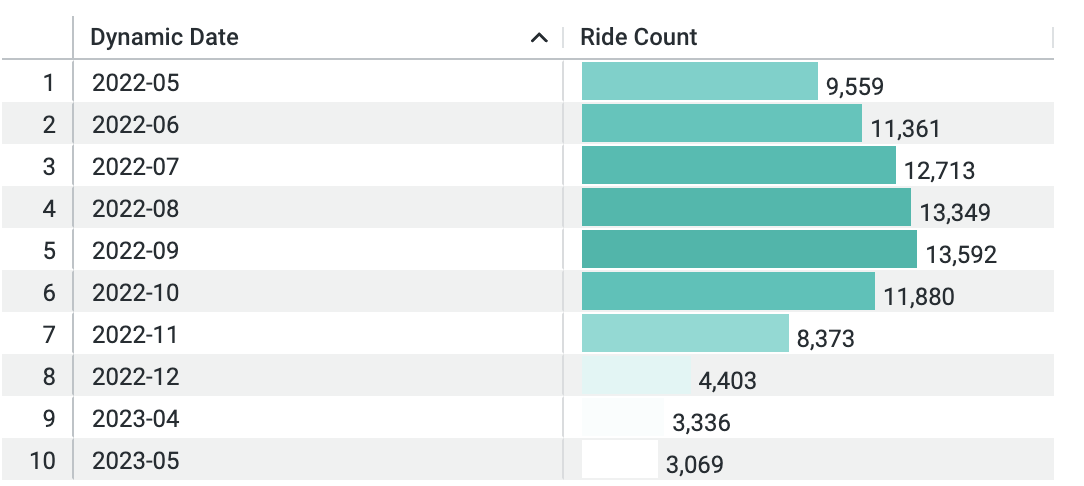
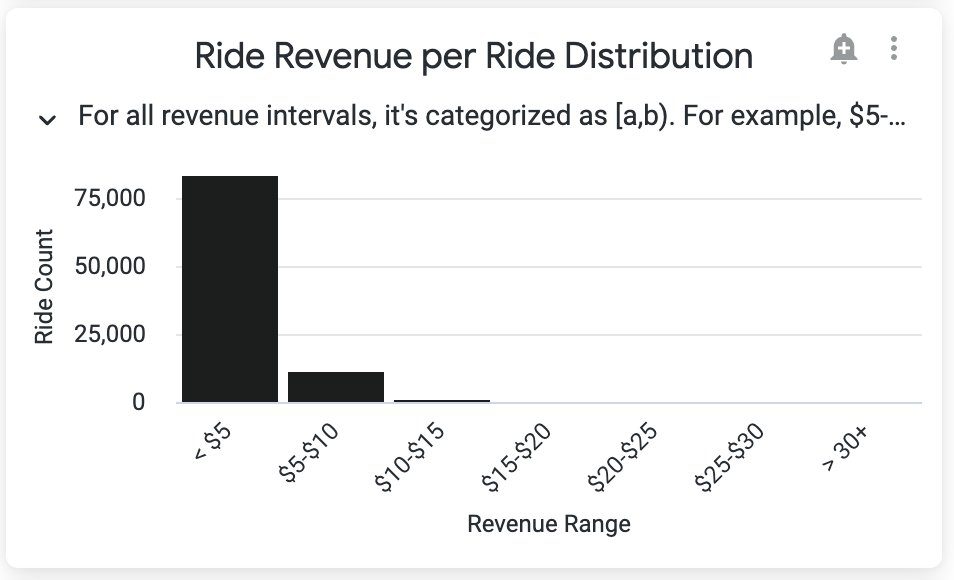
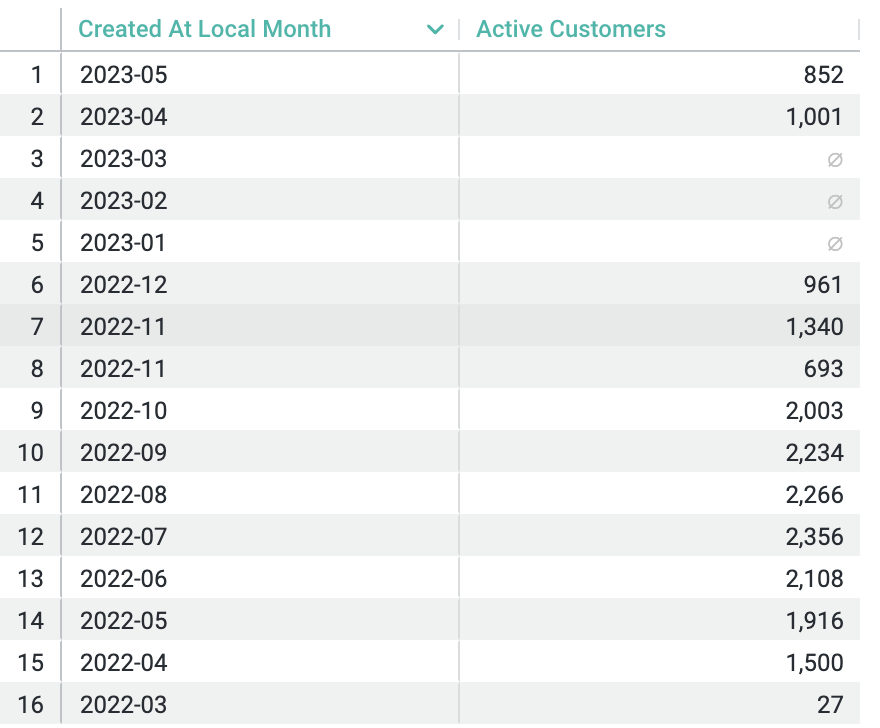


## Pricing
Market - MNE or SAR
MNE has pricing of `$1` unlock fee and 0.39 per minute price for both Astros and Cosmos.
SAR has pricing of `$3` unlock fee (+5 min free ride) and 0.39 per minute price for Astro, Cosmo and E-bike.

## Import

In [173]:
import numpy as np
from scipy.stats import truncnorm
import pandas as pd
import yaml

In [374]:
N_ITERATIONS = 3
SEED_N = 1
BOOLEAN_ASSIGNMENT_THRESHOLD = 0.51  # if probability dist is over this number, assign True
MARKET_NAME = 'MNE'
MNE_UNLOCK_FEE = 1  # USD
MNE_PRICE_PER_MINUTE = 0.39  # USD
SAR_UNLOCK_FEE = 3  # USD
SAR_PRICE_PER_MINUTE = 0.39  # USD
SAR_MINUTES_FREE = 5
MNE_AVG_MAU = 1900  # avg monthly active users
MNE_AVG_MAU_STD = 100  # standard deviation monthly active users
NRC_AVG_MAU = 2000  # avg monthly active users
NRC_AVG_MAU_STD = 100  # standard deviation monthlyactive users
MEDIAN_MONTHLY_RIDES = 3
MIN_RIDES = 1  # Minimum number of rides all customers can take
MAX_RIDES = 4  # Max number of rides all customers can take -- expected that
MNE_MEMBERSHIP_UNLOCK_REDUCTION = -1  # take a dollar off
SAR_MEMBERSHIP_UNLOCK_REDUCTION = -3
TIER1 = 1
TIER2 = 2
TIER3 = 3
T1_MONTHLY_PRICE = 6.99  # USD
T2_MONTHLY_PRICE = 9.99  # USD
T3_MONTHLY_PRICE = 14.99  # USD
T1_UNLOCK_BREAKEVEN = int(np.ceil(T1_MONTHLY_PRICE))
T2_UNLOCK_BREAKEVEN = int(np.ceil(T2_MONTHLY_PRICE))
T3_UNLOCK_BREAKEVEN = int(np.ceil(T3_MONTHLY_PRICE))
T1_MEMBERSHIP_PCT_DISCOUNT = 0
T2_MEMBERSHIP_PCT_DISCOUNT = 0.05  # 5% off entire trip
T3_MEMBERSHIP_PCT_DISCOUNT = 0.15  # 15% off entire trip

def monthly_active_users(market_name):
    if market_name == 'MNE':
        mau = np.random.normal(MNE_AVG_MAU, MNE_AVG_MAU_STD)
    elif market_name == 'NRC':
        mau = np.random.normal(NRC_AVG_MAU, NRC_AVG_MAU_STD)
    else:
        mau = np.nan
        
    return mau


def new_signups_percentage():
    return np.random.beta(1, 9)

# NOTE: we'll init sim by estimating how many customers will be in play
# then we'll estimate if they'll become a member and what tier

def pct_existing_customer_uptake():
    return np.random.beta(2, 8)

def pct_new_customer_uptake():
    return np.random.beta(4, 6)
    
# NOTE: we'll multiply the uptake pcts times the list of customers and
# assign state of True or False if they take it
# but now which tier will they choose? Only applies to ones that get assigned a state of True

# NOTE: keep track of new customers as True or False
def probability_tier_1():
    return np.random.beta(4, 6)

def probability_tier_2():
    return np.random.beta(3, 7)

def probability_tier_3():
    return np.random.beta(2, 8)

def tier_chosen():
    # in order of Tier 1 to 3
    pr = [probability_tier_1(), probability_tier_2(), probability_tier_3()]
    return 1 + np.argmax(pr)

def initial_price_for_ride(market, minutes):
    if market=='MNE':
        ride_price = MNE_UNLOCK_FEE + (MNE_PRICE_PER_MINUTE * minutes)
    if market=='SAR':
        ride_price = SAR_UNLOCK_FEE + (SAR_PRICE_PER_MINUTE * minutes)
    
    return ride_price

def membership_price_adjustment(market, tier, minutes):
    if market=='MNE':
        
        if tier==1:
            adjusted_ride_price = (1 - T1_MEMBERSHIP_PCT_DISCOUNT) * (MNE_PRICE_PER_MINUTE * minutes)
        if tier==2:
            adjusted_ride_price = (1 - T2_MEMBERSHIP_PCT_DISCOUNT) * (MNE_PRICE_PER_MINUTE * minutes)
        if tier==3:
            adjusted_ride_price = (1 - T3_MEMBERSHIP_PCT_DISCOUNT) * (MNE_PRICE_PER_MINUTE * minutes)
            
    if market=='SAR':
        
        if tier==1:
            adjusted_ride_price = (1 - T1_MEMBERSHIP_PCT_DISCOUNT) * (MNE_PRICE_PER_MINUTE * minutes)
        if tier==2:
            adjusted_ride_price = (1 - T2_MEMBERSHIP_PCT_DISCOUNT) * (MNE_PRICE_PER_MINUTE * minutes)
        if tier==3:
            adjusted_ride_price = (1 - T3_MEMBERSHIP_PCT_DISCOUNT) * (MNE_PRICE_PER_MINUTE * minutes)
    
    return adjusted_ride_price
        
# run this only for month 0
# gets the probability that a new signup with a membership will be active next month
def probability_membership_new_signup_active_next_month0():
    # Set the parameters
    minimum = .4
    maximum = .68
    median = .6

    # Calculate the standard deviation
    std = (maximum - minimum) / 4.0

    # Calculate the lower and upper bounds for truncation
    a = (minimum - median) / std
    b = (maximum - median) / std

    # Generate the truncated normal distribution
    distribution = truncnorm(a, b, loc=median, scale=std)
    pr = float(distribution.rvs(1))
    
    return pr

# run this only for month 0
# gets the probability that an existing rider with a membership will be active next month
def probabillity_membership_existing_active_next_month0():
     # Set the parameters
    minimum = .4
    maximum = .6
    median = .53

    # Calculate the standard deviation
    std = (maximum - minimum) / 4.0

    # Calculate the lower and upper bounds for truncation
    a = (minimum - median) / std
    b = (maximum - median) / std

    # Generate the truncated normal distribution
    distribution = truncnorm(a, b, loc=median, scale=std)
    pr = float(distribution.rvs(1))
    
    return pr

# run this only for month 0
# gets the probability that a standard rider will be active next month
def probability_standard_active_next_month0():
    return np.random.normal(0.18, 0.1)

# anything with diminished will be reserved for customers from month 0 to month 2
# run this only for month 2 on month 0 cohort
# def probability_membership_new_signup_active_next_month_0_2():
#     return np.random.normal(0.55, 0.025)

# # run this only for month 2 on month 0 cohort
# def probabillity_membership_existing_active_next_month_0_2():
#     return np.random.normal(.50, .01)

# # run this only for month 2 on month 0 cohort
# def probability_standard_active_next_month_0_2():
#     return np.random.normal(0.2, 0.025)

# run this only for month 1 cohort
# gets the probability that a new signup with a membership will be active next month
def probability_membership_new_signup_active_next_month1():
    # Set the parameters
    minimum = .4
    maximum = .68
    median = .6

    # Calculate the standard deviation
    std = (maximum - minimum) / 4.0

    # Calculate the lower and upper bounds for truncation
    a = (minimum - median) / std
    b = (maximum - median) / std

    # Generate the truncated normal distribution
    distribution = truncnorm(a, b, loc=median, scale=std)
    pr = float(distribution.rvs(1))
    
    return pr


# run this only for month 1 cohort
# gets the probability that an existing member with a membership will be active next month
def probabillity_membership_existing_active_next_month1():
    # Set the parameters
    minimum = .4
    maximum = .6
    median = .53

    # Calculate the standard deviation
    std = (maximum - minimum) / 4.0

    # Calculate the lower and upper bounds for truncation
    a = (minimum - median) / std
    b = (maximum - median) / std

    # Generate the truncated normal distribution
    distribution = truncnorm(a, b, loc=median, scale=std)
    pr = float(distribution.rvs(1))
    
    return pr

# run this only for month 1 cohort
# gets the probability that a standard rider will be active next month
def probability_standard_active_next_month1():
    return np.random.normal(0.18, 0.1)

# Assuming everyone will follow a gamma distribution no matter what case
def apply_ride_price(array_length):
    return np.random.gamma(4.7, 1.2, array_length)

# Actually, instead of a price following gamma, let's do pricing based on minutes
# MNE and SAR follow about the same distribution
# this has a median of around 8 or 9 minutes and goes up to about 40 minutes, which is 95th percentile of data inside of fct_rides
def apply_ride_duration_minutes(array_length):
    return np.clip(np.random.gamma(3, 3.2, array_length), a_min=2, a_max=None)


def apply_number_of_rides(array_length):
    initial_rides = 1 + np.arange(4)
    pr_initial_rides = [.1, .3, .55, .05]
    
    return np.random.choice(initial_rides, p=pr_initial_rides, size=array_length)


def rider_tries_to_make_up_for_monthly_price():
    # will apply to initial rides if rides < break even unlock fee
    choice_array = [True, False]
    pr_choice = [0.23, 0.77]
    
    return np.random.choice(choice_array, p=pr_choice)


# NOTE: So then how many rides will each customer take?
# We assume monthly median of 3
# use this function to add 0 to 3 additional rides
# think of this as a lighter version of people trying to make up for monthly price
# heavier probability on not taking additional rides
def additional_monthly_rides_from_membership(array_length):
    additional_rides = np.arange(3)
    pr_additional_rides = [0.7, 0.2, 0.1]
    
    return np.random.choice(additional_rides, p=pr_additional_rides, size=array_length)
    

def roll_the_dice_month0(market_name):
    _mau = int(monthly_active_users(market_name))
    _new_signups_percentage = new_signups_percentage()
    _existing_customer_uptake_percentage = pct_existing_customer_uptake()
    _new_customer_uptake_percentage = pct_new_customer_uptake()
    _probability_membership_new_signup_active_next_month0 = probability_membership_new_signup_active_next_month0()
    _probabillity_membership_existing_active_next_month0 = probabillity_membership_existing_active_next_month0()
    _probability_standard_active_next_month0 = probability_standard_active_next_month0()
    
    return _mau, _new_signups_percentage, _existing_customer_uptake_percentage, _new_customer_uptake_percentage, _probability_membership_new_signup_active_next_month0, _probabillity_membership_existing_active_next_month0, _probability_standard_active_next_month0


def roll_the_dice_month1(market_name):
    _mau = int(monthly_active_users(market_name))
    _new_signups_percentage = new_signups_percentage()
    _existing_customer_uptake_percentage = pct_existing_customer_uptake()
    _new_customer_uptake_percentage = pct_new_customer_uptake()
    _probability_membership_new_signup_active_next_month1 = probability_membership_new_signup_active_next_month1()
    _probabillity_membership_existing_active_next_month1 = probabillity_membership_existing_active_next_month1()
    _probability_standard_active_next_month1 = probability_standard_active_next_month1()
    
    return _mau, _new_signups_percentage, _existing_customer_uptake_percentage, _new_customer_uptake_percentage, _probability_membership_new_signup_active_next_month1, _probabillity_membership_existing_active_next_month1, _probability_standard_active_next_month1


    

In [375]:
results = list()
for i in range(N_ITERATIONS):
    seed = np.random.seed(i)
    iteration = i
    month = 0
    
    # STEP 1: Roll the dice for month 0
    mau, \
    new_signups_percentage, \
    existing_customer_uptake_percentage, \
    new_customer_uptake_percentage, \
    probability_membership_new_signup_active_next_month0, \
    probabillity_membership_existing_active_next_month0, \
    probability_standard_active_next_month0 = roll_the_dice_month0(MARKET_NAME)
    
    # STEP 2: Create the customer indices
    # assumes that initial MAU is estimated from previous month
    existing_customers_month0 = mau
    new_signups_month0 = int(existing_customers_month0 * new_signups_percentage)
    total_customer_list = np.arange(existing_customers_month0 + new_signups_month0)
    
    # STEP 3: Existing customer or new customer sign up
    existing_customer_month = total_customer_list
    existing_customer_month[:mau] = True
    existing_customer_month[mau:] = False
    
    # STEP 4: Work out of a dataframe to make this easier
    results_df0 = pd.DataFrame()
    results_df0['iteration'] = iteration
    results_df0['month'] = month
    results_df0['customers'] = total_customer_list
    results_df0['is_existing_customer'] = existing_customer_month
    
    
    # STEP 5: Assign the membership signup boolean
    results_df0['membership_signed_up'] = False
    existing_customers = results_df0.loc[results_df0['is_existing_customer']==True, 'customers']
    n_existing_customers_chosen = int(len(existing_customers) * existing_customer_uptake_percentage)
    existing_customers_chosen = np.random.choice(existing_customers, 
                                                 size=n_existing_customers_chosen, 
                                                 replace=False)
    
    results_df0.loc[results_df0['customers'].isin(existing_customers_chosen), 'membership_signed_up'] = True
    
    new_customers = results_df0.loc[results_df0['is_existing_customer']==False, 'customers']
    n_new_customers_chosen = int(len(new_customers) * new_customer_uptake_percentage)
    new_customers_chosen = np.random.choice(new_customers,
                                            size=n_new_customers_chosen,
                                            replace=False)
    results_df0.loc[results_df0['customers'].isin(new_customers_chosen), 'membership_signed_up'] = True
    
    # STEP 6: For people who signed up, which tier did they choose?
    results_df0['tier_chosen'] = np.nan
    results_df0['membership_revenue'] = 0.0
    array_length = results_df0.loc[results_df0['membership_signed_up']==True].shape[0]
    results_df0.loc[results_df0['membership_signed_up']==True, 'tier_chosen'] = [tier_chosen() for i in range(array_length)]
    
    # STEP 7: How many rides did each person take this month?
    results_df0['rides_taken'] = 0
    array_length = len(results_df0['rides_taken'])
    results_df0['rides_taken'] = apply_number_of_rides(array_length)
    
    # STEP 7A: What is initial number of rides if membership riders decide to try and make up for monthly price with unlock fee waived?
    for idx, row in results_df0.loc[results_df0['membership_signed_up']==True].iterrows():
        # TODO: finish the adjustment routine to account for people wanting to make up for the monthly price
        tier_chosen = row['tier_chosen']
        initial_rides = row['rides_taken']
        will_make_attempt = rider_tries_to_make_up_for_monthly_price()
        
        if will_make_attempt:
            if tier_chosen == TIER1 and initial_rides < T1_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T1_UNLOCK_BREAKEVEN - np.random.choice([0, 1, 2, 3], p=[.1, .2, .2, .5])
                row['membership_revenue'] = T1_MONTHLY_PRICE
            elif tier_chosen == TIER2 and initial_rides < T2_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T2_UNLOCK_BREAKEVEN - np.random.choice([0, 1, 2, 3, 4], p=[.01, .09, .15, .25, .5])
                row['membership_revenue'] = T2_MONTHLY_PRICE
            elif tier_chosen == TIER3 and initial_rides < T3_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T3_UNLOCK_BREAKEVEN - (int(10 * np.random.beta(2, 8)))
                row['membership_revenue'] = T3_MONTHLY_PRICE
            else:
                continue
        else:
            continue
    
    # STEP 8: How many additional rides did a membership customer take this month?
    results_df0['additional_rides_taken'] = np.nan
    array_length = len(results_df0[results_df0['membership_signed_up']==True])
    results_df0.loc[results_df0['membership_signed_up']==True, 'additional_rides_taken'] = additional_monthly_rides_from_membership(array_length)
    
    results_df0['total_rides_taken'] = results_df0['rides_taken'] + results_df0['additional_rides_taken']
    
    
    # STEP 9: Based on the monthly rides taken, assign the total minutes per trip where probability distribution is called for each trip taken
    # and get the ride revenue based on the state of the customer
    
    results_df0['initial_ride_revenue'] = np.nan
    results_df0['initial_ride_revenue_array'] = np.nan
    results_df0['adjusted_revenue'] = np.nan
    results_df0['adjusted_revenue_array'] = np.nan
    results_df0['total_minutes'] = np.nan
    results_df0['ride_minutes_array'] = np.nan
    
    for idx, row in results_df0.iterrows():
        num_rides = row['total_rides_taken']
        tier_chosen = row['tier_chosen']
        
        ride_minutes_array = apply_ride_duration_minutes(num_rides)
        initial_ride_revenue_array = [initial_price_for_ride(MARKET_NAME, ride_minute) for ride_minute in ride_minutes_array]
        adjusted_ride_revenue_array = [membership_price_adjustment(MARKET_NAME, tier_chosen, ride_minute) for ride_minute in ride_minutes_array]
        
        total_minutes = np.sum(ride_minutes_array)
        total_initial_ride_revenue = np.sum(initial_ride_revenue_array)
        total_adjusted_ride_revenue = np.sum(adjusted_ride_revenue_array)
        
        row['initial_ride_revenue'] = total_initial_ride_revenue
        row['initial_ride_revenue_array'] = str(initial_ride_revenue_array)
        
        row['adjusted_revenue'] = total_adjusted_ride_revenue
        row['adjusted_revenue_array'] = str(adjusted_ride_revenue_array)
        
        row['total_minutes'] = total_minutes
        row['ride_minutes_array'] = str(ride_minutes_array)
    
    results_df0.to_csv(f'./data/i{iteration}_m{month}_results.csv', index=False)
        
    ################# END MONTH 0  #################
    # ################# ################# #################
    # NOW LET'S LOOK AT MONTH 1 (Second Month)
    month = 1
    
    # how many of the new membership customers from previous month (month 0) be active this month (month 1)?
    num_existing_and_membership_signup = results_df0.loc[(results_df0['is_existing_customer']==True) & (results_df0['membership_signed_up']==True)].shape[0]
    num_new_and_membership_signup = results_df0.loc[(results_df0['is_existing_customer']==False) & (results_df0['membership_signed_up']==True)].shape[0]
    num_standard_riders = results_df0.loc[results_df0['membership_signed_up']==False].shape[0]
    
    active_customers_into_month1 = int(np.sum([(num_standard_riders * probability_standard_active_next_month0),
                                               (num_new_and_membership_signup * probability_membership_new_signup_active_next_month0),
                                               (num_existing_and_membership_signup * probabillity_membership_existing_active_next_month0)]))
    
    # NOTE: Assuming that these active customers will be in addition to the historical MAU count
    # which says that memberships will add to the historical MAU + new signups we expect
    # new signups percentage will be applied to the mau selected from the generator
    
    mau_month1, \
    new_signups_percentage_month1, \
    existing_customer_uptake_percentage_month1, \
    new_customer_uptake_percentage_month1, \
    probability_membership_new_signup_active_next_month1, \
    probabillity_membership_existing_active_next_month1, \
    probability_standard_active_next_month1 = roll_the_dice_month1(MARKET_NAME)
    
     # STEP 2: Create the customer indices
    # assumes that initial MAU is estimated from previous month
    num_existing_customers_month1 = int(mau) + active_customers_into_month1
    new_signups_month1 = int(num_existing_customers_month1 * new_signups_percentage_month1)
    total_customer_list_month1 = np.arange(num_existing_customers_month1 + new_signups_month1)
    
    # STEP 3: Existing customer or new customer sign up
    existing_customer_month_list = total_customer_list_month1
    existing_customer_month_list[:num_existing_customers_month1] = True
    existing_customer_month_list[num_existing_customers_month1:] = False
            
    
    # STEP 4: Work out of a dataframe to make this easier
    results_df1 = pd.DataFrame()
    results_df1['iteration'] = iteration
    results_df1['month'] = month
    results_df1['customers'] = total_customer_list_month1
    results_df1['is_existing_customer'] = existing_customer_month_list
    
    # STEP 5: Assign the membership signup boolean
    # this needs to change a bit to keep the membership status for those that signed up for it month 0
    results_df1['membership_signed_up'] = False
    
      # here is the line of code to adjust this for pre-existing membership people
    # this is meant to be from month0...don't change
    # this looks at people who are existing but have been assigned as false for signing up
    num_active_membership_riders_month0 = int(np.sum([(num_new_and_membership_signup * probability_membership_new_signup_active_next_month0),
                                                      (num_existing_and_membership_signup * probabillity_membership_existing_active_next_month0)]))
    counter = 1
    for idx, row in results_df1.loc[(results_df1['is_existing_customer']==True) & (results_df1['membership_signed_up']==False)].iterrows():
        if counter <= num_active_membership_riders_month0:
            row['membership_signed_up'] = True
            counter += 1
        else:
            continue
   
    # the above adjustment routine was brought upwards so that we don't double select customers that get assigned to signup for the membership
    existing_customers = results_df1.loc[(results_df1['is_existing_customer']==True) & (results_df1['membership_signed_up']==False), 'customers']
     # End of adjustment for existing membership riders
    n_existing_customers_chosen = int(len(existing_customers) * existing_customer_uptake_percentage_month1)
    existing_customers_chosen = np.random.choice(existing_customers, 
                                                 size=n_existing_customers_chosen, 
                                                 replace=False)
    
    results_df1.loc[results_df1['customers'].isin(existing_customers_chosen), 'membership_signed_up'] = True
                                                                                             
  
    
    new_customers = results_df1.loc[results_df1['is_existing_customer']==False, 'customers']
    n_new_customers_chosen = int(len(new_customers) * new_customer_uptake_percentage)
    new_customers_chosen = np.random.choice(new_customers,
                                            size=n_new_customers_chosen,
                                            replace=False)
    results_df1.loc[results_df1['customers'].isin(new_customers_chosen), 'membership_signed_up'] = True
    
    # STEP 6: For people who signed up, which tier did they choose?
    # given that the selection for who would be active from memberships is random, we should be okay resetting the tier selections for the next month
    # NOTE: Audit that assumption ^^
    results_df1['tier_chosen'] = np.nan
    results_df1['membership_revenue'] = 0.0
    array_length = results_df1.loc[results_df1['membership_signed_up']==True].shape[0]
    results_df1.loc[results_df1['membership_signed_up']==True, 'tier_chosen'] = [tier_chosen() for i in range(array_length)]
    
    # STEP 7: How many rides did each person take this month?
    results_df1['rides_taken'] = 0
    array_length = results_df1.shape[0]
    results_df1['rides_taken'] = apply_number_of_rides(array_length)
    
    # STEP 7A: What is initial number of rides if membership riders decide to try and make up for monthly price with unlock fee waived?
    for idx, row in results_df0.loc[results_df0['membership_signed_up']==True].iterrows():
        # TODO: finish the adjustment routine to account for people wanting to make up for the monthly price
        tier_chosen = row['tier_chosen']
        initial_rides = row['rides_taken']
        will_make_attempt = rider_tries_to_make_up_for_monthly_price()
        
        if will_make_attempt:
            if tier_chosen == TIER1 and initial_rides < T1_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T1_UNLOCK_BREAKEVEN - np.random.choice([0, 1, 2, 3], p=[.1, .2, .2, .5])
                row['membership_revenue'] = T1_MONTHLY_PRICE
            elif tier_chosen == TIER2 and initial_rides < T2_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T2_UNLOCK_BREAKEVEN - np.random.choice([0, 1, 2, 3, 4], p=[.01, .09, .15, .25, .5])
                row['membership_revenue'] = T2_MONTHLY_PRICE
            elif tier_chosen == TIER3 and initial_rides < T3_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T3_UNLOCK_BREAKEVEN - (int(10 * np.random.beta(2, 8)))
                row['membership_revenue'] = T3_MONTHLY_PRICE
            else:
                continue
        else:
            continue
    
    # STEP 8: How many additional rides did a membership customer take this month?
    results_df1['additional_rides_taken'] = np.nan
    results_df1.loc[results_df1['membership_signed_up']==True, 'additional_rides_taken'] = additional_monthly_rides_from_membership()
    
    results_df1['total_rides_taken'] = results_df1['rides_taken'] + results_df1['additional_rides_taken']
    
    
    # STEP 9: Based on the monthly rides taken, assign the total minutes per trip where probability distribution is called for each trip taken
    # and get the ride revenue based on the state of the customer
    
    results_df1['initial_ride_revenue'] = np.nan
    results_df1['initial_ride_revenue_array'] = np.nan
    results_df1['adjusted_revenue'] = np.nan
    results_df1['adjusted_revenue_array'] = np.nan
    results_df1['total_minutes'] = np.nan
    results_df1['ride_minutes_array'] = np.nan
    
    for idx, row in results_df1.iterrows():
        num_rides = row['total_rides_taken']
        tier_chosen = row['tier_chosen']
        
        ride_minutes_array = apply_ride_duration_minutes(num_rides)
        initial_ride_revenue_array = [initial_price_for_ride(MARKET_NAME, ride_minute) for ride_minute in ride_minutes_array]
        adjusted_ride_revenue_array = [membership_price_adjustment(MARKET_NAME, tier_chosen, ride_minute) for ride_minute in ride_minutes_array]
        
        total_minutes = np.sum(ride_minutes_array)
        total_initial_ride_revenue = np.sum(initial_ride_revenue_array)
        total_adjusted_ride_revenue = np.sum(adjusted_ride_revenue_array)
        
        row['initial_ride_revenue'] = total_initial_ride_revenue
        row['initial_ride_revenue_array'] = str(initial_ride_revenue_array)
        
        row['adjusted_revenue'] = total_adjusted_ride_revenue
        row['adjusted_revenue_array'] = str(adjusted_ride_revenue_array)
        
        row['total_minutes'] = total_minutes
        row['ride_minutes_array'] = str(ride_minutes_array)
    
    results_df1.to_csv(f'./data/i{iteration}_m{month}_results.csv', index=False)
    
     ################# END MONTH 1  #################
    # ################# ################# #################
    # NOW LET'S LOOK AT MONTH 2 (Third Month)
    
    month = 2
    
    # how many of the new membership customers from first month (month 0) be active this month (month 2)?
    # we should probably roll the dice again to understand the month 0 effects on month 2
#     num_existing_and_membership_signup = results_df0.iloc[results_df0['is_existing_customer']==True & results_df0['membership_signed_up']==True].shape[0]
#     num_new_and_membership_signup = results_df0.iloc[results_df0['is_existing_customer']==False & results_df0['membership_signed_up']==True].shape[0]
#     num_standard_riders = results_df0.iloc[results_df0['membership_signed_up']==False]
    
#     active_customers_into_month2 = int(np.sum([(num_standard_riders * probability_standard_active_next_month0()),
#                                                (num_new_and_membership_signup * probability_membership_new_signup_active_next_month0()),
#                                                (num_existing_and_membership_signup * probabillity_membership_existing_active_next_month0())]))
# NOTE: Maybe we don't need to model the diminished probability of cohort from month 0
    
    # how many of the new membership customers from previous month (month 1) be active this month (month 2)?
    num_existing_and_membership_signup = results_df1.loc[(results_df1['is_existing_customer']==True) & (results_df1['membership_signed_up']==True)].shape[0]
    num_new_and_membership_signup = results_df1.loc[(results_df1['is_existing_customer']==False) & (results_df1['membership_signed_up']==True)].shape[0]
    num_standard_riders = results_df1.loc[results_df1['membership_signed_up']==False].shape[0]
    
    active_customers_into_month2 += int(np.sum([(num_standard_riders * probability_standard_active_next_month1),
                                               (num_new_and_membership_signup * probability_membership_new_signup_active_next_month1),
                                               (num_existing_and_membership_signup * probabillity_membership_existing_active_next_month1)]))
    
    
    # NOTE: Assuming that these active customers will be in addition to the historical MAU count
    # which says that memberships will add to the historical MAU + new signups we expect
    # new signups percentage will be applied to the mau selected from the generator
    
    mau_month2, \
    new_signups_percentage_month2, \
    existing_customer_uptake_percentage_month2, \
    new_customer_uptake_percentage_month2, \
    _, \
    _, \
    _ = roll_the_dice_month2()
    
     # STEP 2: Create the customer indices
    # assumes that initial MAU is estimated from previous month
    num_existing_customers_month2 = int(mau_month2) + active_customers_into_month1
    new_signups_month2 = int(num_existing_customers_month2 * new_signups_percentage_month2)
    total_customer_list_month2 = np.arange(num_existing_customers_month2 + new_signups_month2)
    
    # STEP 3: Existing customer or new customer sign up
    existing_customer_month_list = total_customer_list_month2
    existing_customer_month_list[:num_existing_customers_month2] = True
    existing_customer_month_list[num_existing_customers_month2:] = False
            
    
    # STEP 4: Work out of a dataframe to make this easier
    results_df2 = pd.DataFrame()
    results_df2['iteration'] = iteration
    results_df2['month'] = month
    results_df2['customers'] = total_customer_list_month2
    results_df2['is_existing_customer'] = existing_customer_month_list
    
    # STEP 5: Assign the membership signup boolean
    # this needs to change a bit to keep the membership status for those that signed up for it month 0
    results_df2['membership_signed_up'] = False
    
      # here is the line of code to adjust this for pre-existing membership people
    # this is meant to be from month0...don't change
    # this looks at people who are existing but have been assigned as false for signing up
    num_active_membership_riders_month2 = int(np.sum([(num_new_and_membership_signup * probability_membership_new_signup_active_next_month1),
                                                      (num_existing_and_membership_signup * probabillity_membership_existing_active_next_month1)]))
    counter = 1
    for idx, row in results_df2.loc[(results_df1['is_existing_customer']==True) & (results_df2['membership_signed_up']==False)].iterrows():
        if counter <= num_active_membership_riders_month0:
            row['membership_signed_up'] = True
            counter += 1
        else:
            continue
   
    # the above adjustment routine was brought upwards so that we don't double select customers that get assigned to signup for the membership
    existing_customers = results_df2.loc[(results_df1['is_existing_customer']==True) & (results_df2['membership_signed_up']==False), 'customers']
     # End of adjustment for existing membership riders
    n_existing_customers_chosen = int(len(existing_customers) * existing_customer_uptake_percentage_month2)
    existing_customers_chosen = np.random.choice(existing_customers, 
                                                 size=n_existing_customers_chosen, 
                                                 replace=False)
    
    results_df2.loc[results_df2['customers'].isin(existing_customers_chosen), 'membership_signed_up'] = True
                                                                                             
  
    
    new_customers = results_df2.loc[results_df1['is_existing_customer']==False, 'customers']
    n_new_customers_chosen = int(len(new_customers) * new_customer_uptake_percentage)
    new_customers_chosen = np.random.choice(new_customers,
                                            size=n_new_customers_chosen,
                                            replace=False)
    results_df2.loc[results_df2['customers'].isin(new_customers_chosen), 'membership_signed_up'] = True
    
    # STEP 6: For people who signed up, which tier did they choose?
    # given that the selection for who would be active from memberships is random, we should be okay resetting the tier selections for the next month
    # NOTE: Audit that assumption ^^
    results_df2['tier_chosen'] = np.nan
    results_df2['membership_revenue'] = 0.0
    array_length = results_df2.loc[results_df2['membership_signed_up']==True].shape[0]
    results_df2.loc[results_df2['membership_signed_up']==True, 'tier_chosen'] = [tier_chosen() for i in range(array_length)]
    
    # STEP 7: How many rides did each person take this month?
    results_df2['rides_taken'] = 0
    array_length = results_df2.shape[0]
    results_df2['rides_taken'] = apply_number_of_rides(array_length)
    
    # STEP 7A: What is initial number of rides if membership riders decide to try and make up for monthly price with unlock fee waived?
    for idx, row in results_df2.loc[results_df2['membership_signed_up']==True].iterrows():
        # TODO: finish the adjustment routine to account for people wanting to make up for the monthly price
        tier_chosen = row['tier_chosen']
        initial_rides = row['rides_taken']
        will_make_attempt = rider_tries_to_make_up_for_monthly_price()
        
        if will_make_attempt:
            if tier_chosen == TIER1 and initial_rides < T1_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T1_UNLOCK_BREAKEVEN - np.random.choice([0, 1, 2, 3], p=[.1, .2, .2, .5])
                row['membership_revenue'] = T1_MONTHLY_PRICE
            elif tier_chosen == TIER2 and initial_rides < T2_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T2_UNLOCK_BREAKEVEN - np.random.choice([0, 1, 2, 3, 4], p=[.01, .09, .15, .25, .5])
                row['membership_revenue'] = T2_MONTHLY_PRICE
            elif tier_chosen == TIER3 and initial_rides < T3_UNLOCK_BREAKEVEN:
                row['rides_taken'] = T3_UNLOCK_BREAKEVEN - (int(10 * np.random.beta(2, 8)))
                row['membership_revenue'] = T3_MONTHLY_PRICE
            else:
                continue
        else:
            continue
    
    # STEP 8: How many additional rides did a membership customer take this month?
    results_df2['additional_rides_taken'] = np.nan
    results_df2.loc[results_df2['membership_signed_up']==True, 'additional_rides_taken'] = additional_monthly_rides_from_membership()
    
    results_df2['total_rides_taken'] = results_df2['rides_taken'] + results_df2['additional_rides_taken']
    
    
    # STEP 9: Based on the monthly rides taken, assign the total minutes per trip where probability distribution is called for each trip taken
    # and get the ride revenue based on the state of the customer
    
    results_df2['initial_ride_revenue'] = np.nan
    results_df2['initial_ride_revenue_array'] = np.nan
    results_df2['adjusted_revenue'] = np.nan
    results_df2['adjusted_revenue_array'] = np.nan
    results_df2['total_minutes'] = np.nan
    results_df2['ride_minutes_array'] = np.nan
    
    for idx, row in results_df2.iterrows():
        num_rides = row['total_rides_taken']
        tier_chosen = row['tier_chosen']
        
        ride_minutes_array = apply_ride_duration_minutes(num_rides)
        initial_ride_revenue_array = [initial_price_for_ride(MARKET_NAME, ride_minute) for ride_minute in ride_minutes_array]
        adjusted_ride_revenue_array = [membership_price_adjustment(MARKET_NAME, tier_chosen, ride_minute) for ride_minute in ride_minutes_array]
        
        total_minutes = np.sum(ride_minutes_array)
        total_initial_ride_revenue = np.sum(initial_ride_revenue_array)
        total_adjusted_ride_revenue = np.sum(adjusted_ride_revenue_array)
        
        row['initial_ride_revenue'] = total_initial_ride_revenue
        row['initial_ride_revenue_array'] = str(initial_ride_revenue_array)
        
        row['adjusted_revenue'] = total_adjusted_ride_revenue
        row['adjusted_revenue_array'] = str(adjusted_ride_revenue_array)
        
        row['total_minutes'] = total_minutes
        row['ride_minutes_array'] = str(ride_minutes_array)
    
    results_df2.to_csv(f'./data/i{iteration}_m{month}_results.csv', index=False)
    # TODO: let's work on the agg stats results for each iteration
    # thinking each row is an iteration and then each col is appended with month index suffix
    

/var/folders/gq/p0t2_bws43n6263m5tm0cb580000gn/T/ipykernel_4960/3882760152.py:88: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  results_df0.loc[results_df0['membership_signed_up']==True, 'additional_rides_taken'] = additional_monthly_rides_from_membership(array_length)


TypeError: 'float' object is not callable

In [346]:
test_dict = {'a': [True, False, True, True, False],
             'b': [0, 0 , 0, 0, 0]}


In [348]:
test_dict

{'a': [True, False, True, True, False], 'b': [0, 0, 0, 0, 0]}

In [349]:
test_df = pd.DataFrame(test_dict)

In [350]:
test_df

,a,b
0,True,0
1,False,0
2,True,0
3,True,0
4,False,0


In [356]:
test_df.loc[test_df['a']==True, 'b'] = [1, 2, 3]

In [367]:
test_df.shape[0]

5

In [14]:
np.random.seed(3)
for i in range(10):
    print(np.random.beta(2, 8))

0.36803592501614396
0.16547222000962594
0.2005771147090713
0.1865730941498708
0.2036995438340651
0.07265503152346596
0.1017629012598511
0.10854739239655938
0.0792004467206723
0.1246729516406833


In [46]:
test_array = np.array([np.random.gamma(3, 3.2) for i in range(1000)])

In [20]:
import seaborn as sns

In [212]:
import numpy as np
from scipy.stats import truncnorm

minimum = .4
maximum = .6
median = .53

# Calculate the standard deviation
std = (maximum - minimum) / 4.0

# Calculate the lower and upper bounds for truncation
a = (minimum - median) / std
b = (maximum - median) / std

# Generate the truncated normal distribution
distribution = truncnorm(a, b, loc=median, scale=std)
pr = float(distribution.rvs(1))

<Axes: ylabel='Count'>

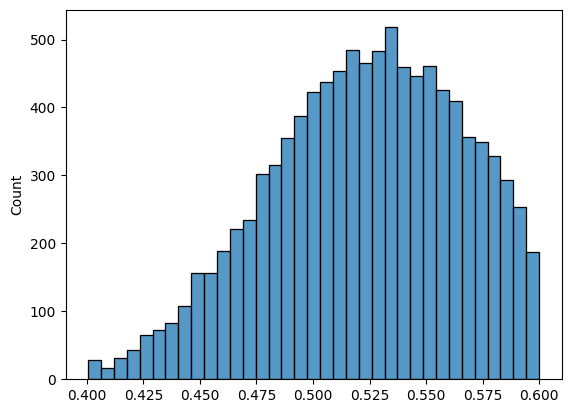

In [213]:
sns.histplot(x=distribution.rvs(10000))

In [206]:
float(truncnorm(a, b, loc=median, scale=std).rvs(1))

0.47930752128555204

<Axes: ylabel='Count'>

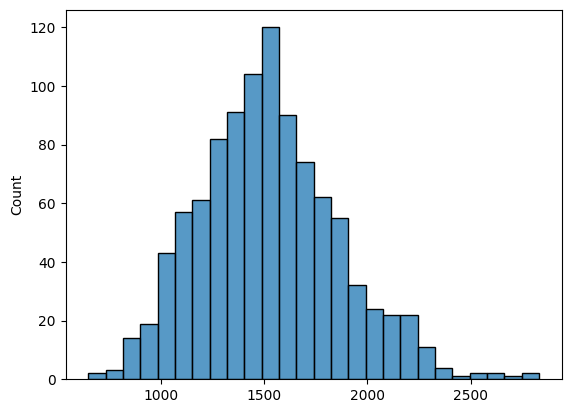

In [219]:
sns.histplot(x=np.random.gamma(19, 81, 1000))

In [296]:
a = np.random.beta(4, 6)

b = np.random.beta(3, 7)

c = np.random.beta(2, 8)

array = np.array([a, b, c])

print(a, b, c)
print(f'Tier chosen: {1 + np.argmax(array)}')

0.4026427112336363 0.374290207522858 0.04236232048566735
Tier chosen: 1


In [314]:
def new_signups_percentage():
    return np.random.beta(1, 9)

In [329]:
a =new_signups_percentage()

In [330]:
a

0.07521079430796038